## A Practical Diffusion Path for Sampling

In this notebook, we will reproduce the experiment made by Anna Korba and O. Chebab in the article: "[A Practical Diffusion Path for Sampling](https://arxiv.org/abs/2406.14040)", 2024.

The main goal is to draw samples from complex target distribution. (...) On s'occupe de la rédaction ensuite car fle


In [1]:
## Python Optimal Transport to compute the Wasserstein distance
pip install pot

  Using cached POT-0.9.4-cp39-cp39-macosx_10_9_x86_64.whl (312 kB)
Note: you may need to restart the kernel to use updated packages.


In [37]:
## Importing standards libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

## Importing libraries for the Gaussian Mixture Model

from scipy.stats import multivariate_normal

## Autograd packages

## Convergence metrics

from scipy.stats import wasserstein_distance
from scipy.stats import entropy # KL-divergence
import ot #Optimal Transport


## Import functions for the experiment : 

from experiment_functions import *


### I. Sampling a Gaussian Mixture with 16 modes

We will compare 3 methods to sample a target distribution which is a Gaussian Mixture with 16 modes : 
- Unadjusted Langevin Algorithm (ULA)
- ULA with geometric path 
- ULA with dilation path

We consider that sample from the target distribution are not available, which make the task of using diffusion models more complicated (except for the dilation path). 

Convergence metrics (aims to quantify the distance between intermediaries distributions and the target distribution) : DEFINE THEM
- KSD
- KL
- MMS

Parameters of the experiment : 
- 1000 particles 
- 10000 iterations
- step size of 0.001 (constant)

------------------------------------------------------------------------------------------------------------------------------------------------------
We start by the first example of the paper, the settings are given here : 

In [358]:
#We define the grid

x = np.linspace(-15, 15, 4)
y = np.linspace(-15, 15, 4)

xx, yy = np.meshgrid(x, y)


## We define the parameters of the target Gaussian Mixture

# We define the centers for each mode
centers = np.c_[xx.ravel(), yy.ravel()] ## On a une matrice de 16 lignes et 2 colonnes, chaque ligne correspond à un centre

# Define the covariance matrix and the weights : 

covariances = np.array([[[3, 0], [0, 3]]]*16)  # cov = 10*I_2 -> 16 times the same covariance matrix
weights = np.ones(16) / 16


# We define the initial position of the particles (sample from a standard normal distribution in 2-dimensions)

sample_init = np.random.randn(1000, 2)


## Other parameters : 

nb_particles = 1000

step_size = 0.001

nb_iter = 10000

We consider that we have access to the gradient of the score of the target distribution, which means that we can implement the ULA. 

We know that the score vector for a $ \mathcal{N}(\mu, \Sigma) $ is given by : 

$ \nabla \log p(x) = \Sigma^{-1}(x- \mu) $ 

As, a Multimodal Normal Distribution as a density that can be written as a weighted sum of $\mathcal{k}$ densities Multivariate Normal : 

$ f(x) = \sum_{i=1}^{k} w_i \cdot \mathcal{N}(x \mid \mu_i, \Sigma_i) $

where :

- $ (w_i)_{i:n} $ is the vector of weights of the $\mathcal{k}$ normal distributions 
- $\mathcal{N}(x \mid \mu_i, \Sigma_i) $ is the density of the i^th normal distribution which composes the multimodal
- $\sum_{i=1}^{k} w_i = 1 $, guarantees that the function is a density




------------------------------------------------------------------------------------------------------------------------------------------------------
Function to generate a graph of 2-dimensionnal Gaussian Mixture Distribution

In [3]:
evaluate_gaussian_mixture(np.array([0]), np.array([1]), np.array([0]), np.array([1]))

0.3989422804014327

#### Gradient of the score of a multimodal : 

$ \nabla \log f(x)$ is computed as follow : 

$ \nabla \log f(x) = \sum_{i=1}^{k} \frac{w_i}{f(x)} \cdot \Sigma_i^{-1} (x - \mu_i) \cdot \mathcal{N}(x \mid \mu_i, \Sigma_i) $

Where :
- $ f(x) $ is the density of the multimodal distribution

------------------------------------------------------------------------------------------------------------------------------------------------------
We define a function which computes to score vector of a Gaussian Mixture distribution given its parameters : 

In [4]:
grad_multimodal_opti(np.array([[1,1], [2, 2], [3, 3]]), weights, centers, covariances)

array([[1.21851601, 1.21851601],
       [0.99576328, 0.99576328],
       [0.66651534, 0.66651534]])

### Unadjusted Langevin Algorithm

Description of the idea : Blabla

------------------------------------------------------------------------------------------------------------------------------------------------------
We define a function for the Unadjusted Langevin Algorithm given : 
- The initial position of the particle $ x_o $ (in our case drawn from a standard Gaussian distribution)
- The parameters of the gaussian mixture (just used to compute the score vector because we consider that we cannot have access to samples of the target distribution)
- The number of iterations until we stop the algorithm
- The step size (considered constant here because "Unadjusted")

Definition of the parameters of the experiment : 
- 1000 particles 
- 10000 iterations
- step size of 0.001 (constant)
- Linear Schedule : $ \forall \mathbb{t} \in \mathbb{R^+} , \lambda_t = \min(1, \mathbb{t}) $


In [ ]:
ULA(sample_init, 10000, 0.001, weights, centers, covariances)

### Dilation Path

Description de la technique : 

------------------------------------------------------------------------------------------------------------------------------------------------------
We define a function for the Unadjusted Langevin Algorithm, with Dilation Path. It means that we apply the same equation to update the position of each particle (not-stochastic, constant step size, ...), but with intermediate distributions. 

The parameters of the algo : 
- The initial position of the particle $ x_o $ (in our case drawn ...)
- The parameters of the gaussian mixture (just used to compute the score vector because we consider that we cannot have access to samples of the target distribution and we can apply the algo by just being able to compute a score vector)
- The number of iterations until we stop the algorithm
- The step size (considered constant here because "Unadjusted")

We keep the same parameters than the previous case (ULA), except for the initialisation that we manually set as $ x_0 = (0,0)$ (question about it)


In [ ]:
ULA_dilation(sample_init, 100, 0.0001, weights, centers, covariances, 1, alpha = 0.002) #1 schedule

------------------------------------------------------------------------------------------------------------------------------------------------------
Experiment with farer modes : The results are clearer because the ULA takes and exponential time (function of the distance between the modes) to reach a new mode 

In [ ]:
x = np.linspace(-70, 70, 4)
y = np.linspace(-70, 70, 4)

xx, yy = np.meshgrid(x, y)

# We define the centers for each mode
centers = np.c_[xx.ravel(), yy.ravel()] ## On a une matrice de 16 lignes et 2 colonnes, chaque ligne correspond à un centre

# Define the covariance matrix
covariances = np.array([[[10, 0], [0, 10]]]*16)  # cov = 10*I_2 -> 16 times the same covariance matrix
weights = np.ones(16) / 16

100%|██████████| 20000/20000 [03:24<00:00, 97.98it/s] 


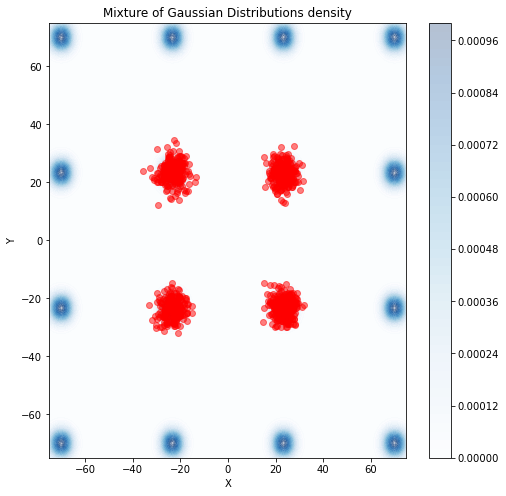

Temps d'exécution pour plot le graph est: 1.908160924911499 secondes


'The magnitude of the Stochastic term is 0.17724648710174917 whereas the magnitude of the gradient term is 0.005029482255721319'

In [526]:
ULA(sample_init, 20000, 0.01, weights, centers, covariances)

Geometric Path 

100%|██████████| 2000/2000 [00:24<00:00, 82.60it/s] 


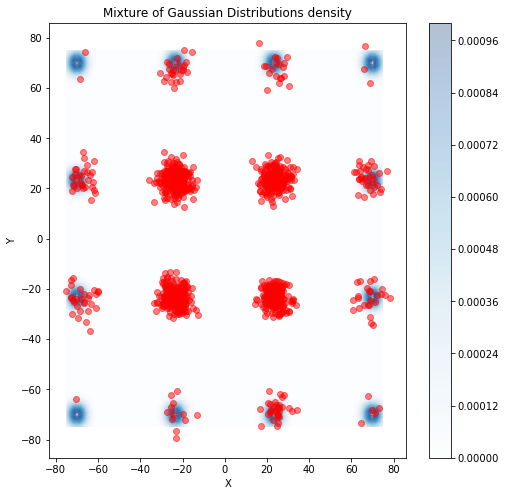

Temps d'exécution pour plot le graph est: 2.0963048934936523 secondes
The magnitude of the Stochastic term is 0.17723776894804616 whereas the magnitude of the gradient term is 0.026085004024898304


' Voici le step moyen sur toutes les particles 0.010000000000000163, et voici le time moyen auquel on est sur la simu 20.000000000000334'

In [573]:
ULA_geometric(sample_init, weights, centers, covariances, 0.01, 20000)

Dilation path with a linear schedule : 

  0%|          | 0/20000 [00:00<?, ?it/s]/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_40765/681934052.py:32: RuntimeWarning: divide by zero encountered in true_divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_40765/681934052.py:32: RuntimeWarning: invalid value encountered in true_divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
100%|██████████| 20000/20000 [02:21<00:00, 141.16it/s]


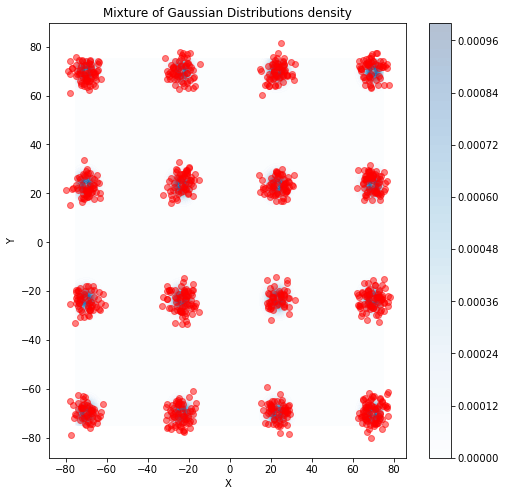

Temps d'exécution pour plot le graph est: 0.9533529281616211 secondes
The magnitude of the Stochastic term is nan whereas the magnitude of the gradient term is nan


' Voici le step moyen sur toutes les particles nan, et voici le time moyen auquel on est sur la simu nan'

In [528]:
ULA_dilation(sample_init, 20000, 0.02, weights, centers, covariances, alpha = 0.01)

### ULA with geometric path

Description : 

------------------------------------------------------------------------------------------------------------------------------------------------------
As previously, we define a function to run the ULA, with geometric path for one particle. We also define the function to plot the result and we have the same parameters as previously

Schedule jusqu'à T = 3

100%|██████████| 10000/10000 [01:17<00:00, 128.27it/s]


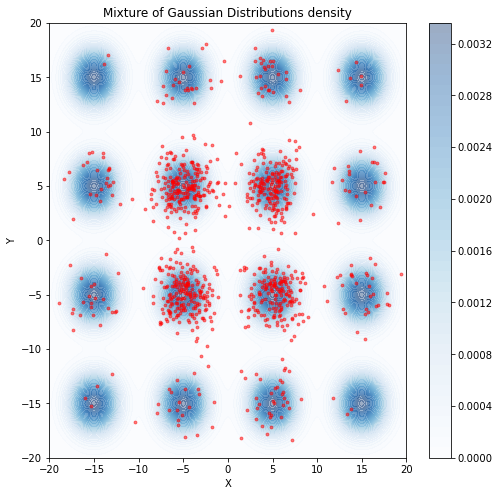

The magnitude of the Stochastic term is 0.0560468127326337 whereas the magnitude of the gradient term is 0.001194071129035955


' Voici le step moyen sur toutes les particles 0.00099999999999999, et voici le time moyen auquel on est sur la simu 9.999999999999899'

In [9]:
sample_init = np.random.randn(1000, 2)
ULA_geometric(sample_init, weights, centers, covariances, 0.001, 10000, 3)

### Taming scheme and Dilation path

To prevent the process to diverge, which can be the case for many reasons with the classic ULA, at each iteration we correct the gradient term with a family of coefficients as in the article : "[The Tamed Unadjusted Langevin Algorithm](https://arxiv.org/abs/1710.05559)"

$ X_{k+1} = X_k - \gamma G_\gamma(X_k) + \sqrt{2 \gamma} Z_{k+1}, \quad X_0 = x_0 $

où 

$ G_\gamma(x) = \frac{\nabla U(x)}{1 + \gamma \|\nabla U(x)\|} $ for the TULA

et 

$ G_{\gamma, c}(x) = \frac{\partial_i U(x)}{1 + \gamma |\partial_i U(x)|} $ for the TULA coordinate-wise (TULAc)


100%|██████████| 10000/10000 [00:54<00:00, 182.98it/s]


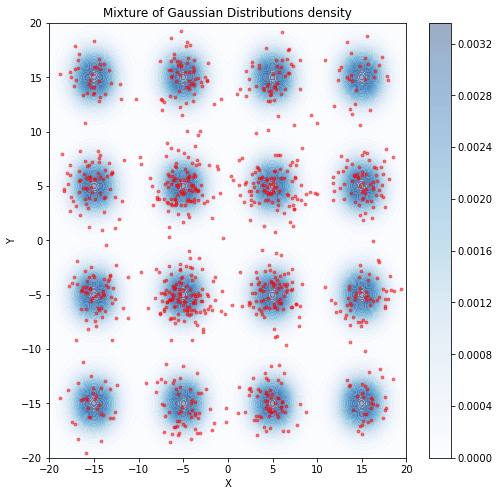

 Voici le step moyen sur toutes les particles 0.020000000000002852, et voici le time moyen auquel on est sur la simu 200.00000000002854


'The magnitude of the Stochastic term is 0.25062263424181697 whereas the magnitude of the gradient term is 0.01426603651767056'

In [18]:
sample_init = np.random.randn(1000, 2) 
TULA_dilation(sample_init, 10000, 0.02, weights, centers, covariances, 5) ### ATTENTION STEP est le vrai step constant

100%|██████████| 10000/10000 [01:31<00:00, 109.51it/s]


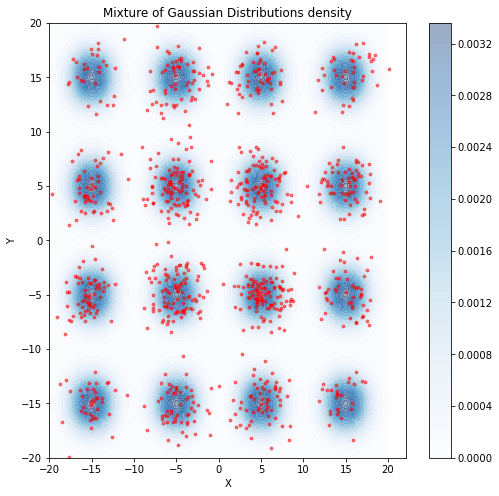

 Voici le step moyen sur toutes les particles 0.020000000000002852, et voici le time moyen auquel on est sur la simu 200.00000000002854


'The magnitude of the Stochastic term is 0.2506985997145726 whereas the magnitude of the gradient term is 0.014328192234579477'

In [362]:
sample_init = np.random.randn(1000, 2) 
TULAc_dilation(sample_init, 10000, 0.02, weights, centers, covariances, 0.001, 5)

Here we are going to define the TULAc as in the paper to see the difference : 

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/tomrossa/Documents/Imperial College/Research_Project-Imperial_College/experiment_functions.py:123: RuntimeWarning: invalid value encountered in true_divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
100%|██████████| 10000/10000 [01:36<00:00, 103.15it/s]


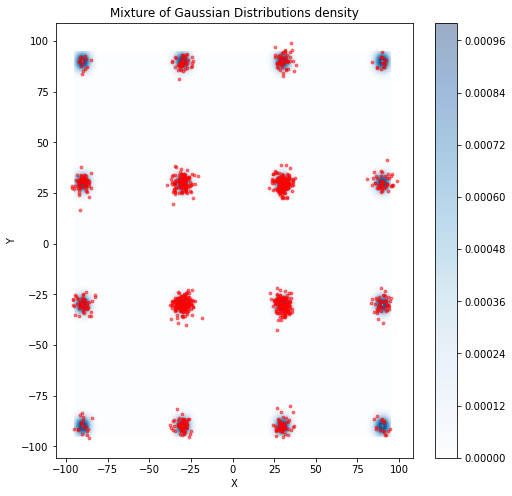

 Voici le step moyen sur toutes les particles 0.010000000000001426, et voici le time moyen auquel on est sur la simu 100.00000000001427


'The magnitude of the Stochastic term is 0.17726525847317676 whereas the magnitude of the gradient term is 0.009266244302540137'

In [23]:
sample_init = np.random.randn(1000, 2)
TULAc_dilation(sample_init, 10000, 0.01, weights, centers, covariances, 50)

------------------------------------------------------------------------------------------------------------------------------------------------------
Let's plot the same graphs as in the article :

20,000 iterations and 20 particles

In [44]:
x = np.linspace(-20, 20, 4)
y = np.linspace(-20, 20, 4)

nb_particles = 20

xx, yy = np.meshgrid(x, y)

# We define the centers for each mode
centers = np.c_[xx.ravel(), yy.ravel()] ## On a une matrice de 16 lignes et 2 colonnes, chaque ligne correspond à un centre

# Define the covariance matrix
covariances = np.array([[[10, 0], [0, 10]]]*16)  # cov = 10*I_2 -> 16 times the same covariance matrix
weights = np.ones(16) / 16

# We define the initial position of the particles (sample from a standard normal distribution in 2-dimensions)
sample_init = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], nb_particles)

### II. 40-modes Gaussian Mixture

In this part, we will reproduce the second part of the experiment. All the parameters of the experiement are the same as previously except the parameters of the target distribution : 40 modes and the no longer equally-weighted and the step is 0.01 to have a faster convergence (10 times more than in the article a priori)

In [416]:
## Let's set the parameters of the new target : 

weights = np.random.uniform(0, 1, 40)
weights = weights / np.sum(weights)

centers = np.random.uniform(-50, 50, (40, 2))

covariances = np.array([[10, 0], [0, 10]] * 40).reshape((40, 2, 2)) #10*I_2 pour chaque composante de la Mixture

sample_init = np.random.randn(1000, 2)

100%|██████████| 20000/20000 [03:57<00:00, 84.27it/s] 


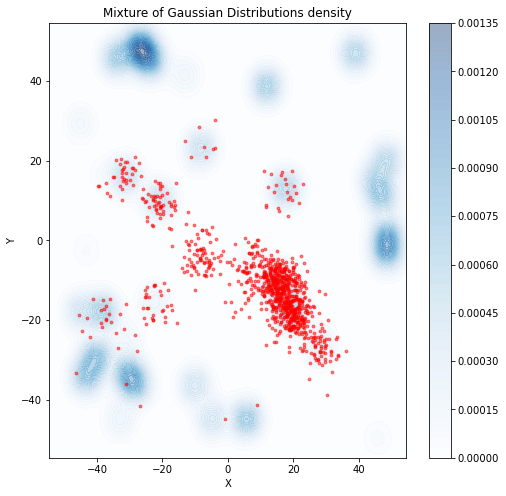

'The magnitude of the Stochastic term is 0.17720949390547447 whereas the magnitude of the gradient term is 0.0034489749881326495'

In [5]:
ULA(sample_init, 20000, 0.01, weights, centers, covariances)

100%|██████████| 20000/20000 [03:02<00:00, 109.49it/s]


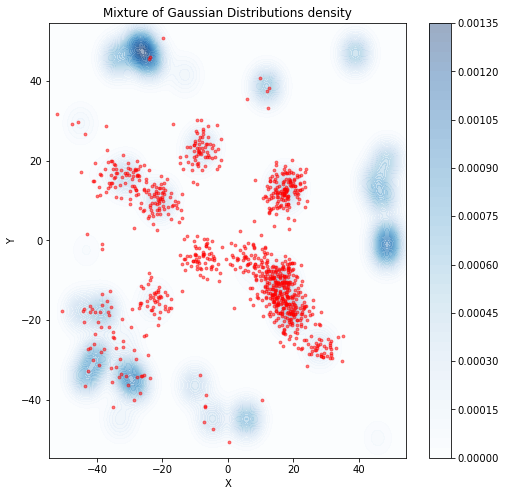

 Voici le step moyen sur toutes les particles 0.009999999999998153, et voici le time moyen auquel on est sur la simu 199.99999999996317


'The magnitude of the Stochastic term is 0.17725945230588264 whereas the magnitude of the gradient term is 0.004049797879266686'

In [6]:
ULA_geometric(sample_init, weights, centers, covariances, 0.01, 20000, 4)

100%|██████████| 10000/10000 [01:30<00:00, 110.54it/s]


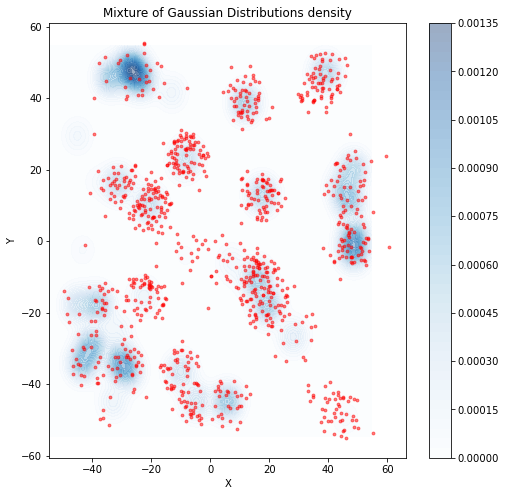

 Voici le step moyen sur toutes les particles 0.0184012401206056, et voici le time moyen auquel on est sur la simu 184.01240120605604


'The magnitude of the Stochastic term is 0.21817726474292481 whereas the magnitude of the gradient term is 0.009999830546575985'

In [7]:
ULA_dilation(sample_init, 10000, 0.05, weights, centers, covariances, 100, alpha = 0.01)

100%|██████████| 10000/10000 [02:13<00:00, 75.04it/s]


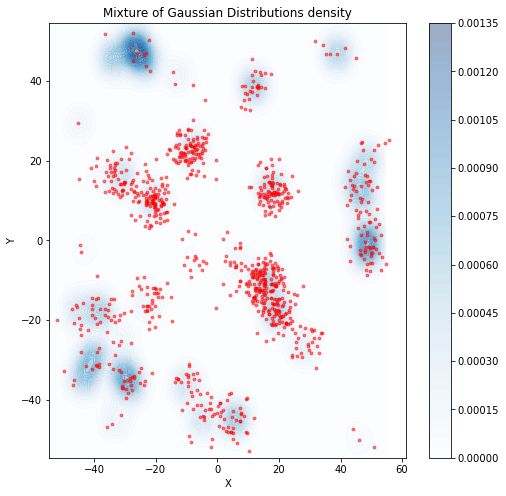

 Voici le step moyen sur toutes les particles 0.020000000000002852, et voici le time moyen auquel on est sur la simu 200.00000000002854


'The magnitude of the Stochastic term is 0.25063625477738105 whereas the magnitude of the gradient term is 0.010449666255066336'

In [12]:
TULA_dilation(sample_init, 10000, 0.01, weights, centers, covariances, 100)

100%|██████████| 10000/10000 [02:18<00:00, 72.26it/s]


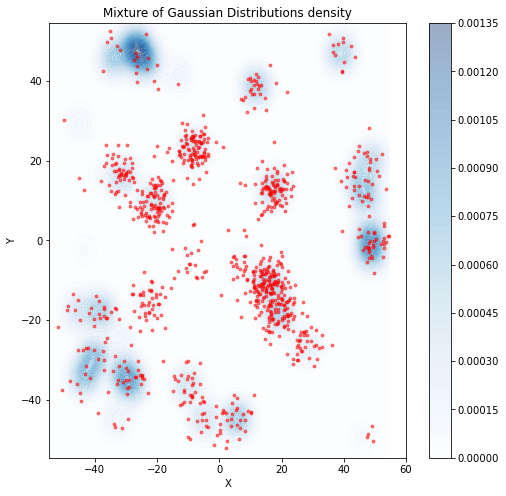

 Voici le step moyen sur toutes les particles 0.020000000000002852, et voici le time moyen auquel on est sur la simu 200.00000000002854


'The magnitude of the Stochastic term is 0.25064663494516215 whereas the magnitude of the gradient term is 0.010500485678521278'

In [13]:
TULAc_dilation(sample_init, 10000, 0.02, weights, centers, covariances, 100)

In this example, we will reproduce the plots of the evolution of some divergence metrics function of the number of iterations (not always fair comparison because not based on the exact time of the experiment...). 

We start by the MMS et Wasserstein distance metrics : 

First, we generate a sample of the target distribution 

REMARQUES IMPORTANTES : 

- Pour générer une mixture gaussienne on choisit l'une des normales de la mixture avec la probabilité de son poid et on génère selon cette dernière. Le fait que la densité de la mixture soit la somme pondérée des densités vient de la formule des probabilités totales. 
- Les méthodes pour avoir la distance Wasserstein et la KL divergence que j'ai importées ne sont pas faites pour les distributions multidimensionnelles, il faut trouver d'autres packages (ou pk pas flatten et réfléchir si ça fait sens...)

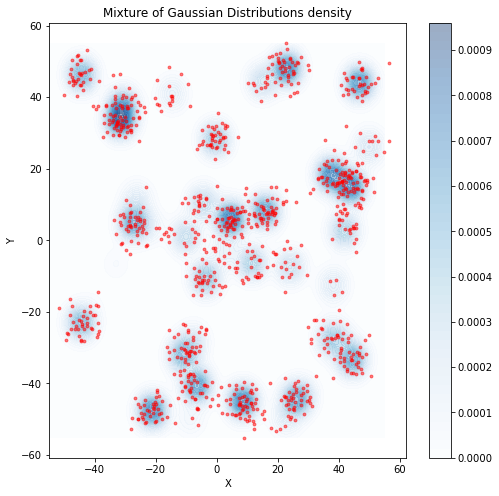

In [417]:
nb_components = len(weights)
target_sample = np.zeros((1000, 2))

# Sélectionner les composantes basées sur les poids
component_choices = np.random.choice(nb_components, size=1000, p=weights) #choix aléatoire entre les normales de la mixture (pondéré)

for i in range(nb_components):

    num_samples = np.sum(component_choices == i) #

    if num_samples > 0:

        target_sample[component_choices == i] = np.random.multivariate_normal(mean=centers[i], cov=covariances[i], size=num_samples) #pour les indices où l'on a tiré la composante en question on tire selon celle-ci

generate_multimodal(centers, covariances, weights, target_sample)

Then, we take the sample generated by the ULA at each iteration from 1 to 10,000 and we compute its MMS / Wasserstein distance with the target sample. 

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/tomrossa/Documents/Imperial College/Research_Project-Imperial_College/experiment_functions.py:124: RuntimeWarning: invalid value encountered in true_divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
100%|██████████| 10000/10000 [01:38<00:00, 101.23it/s]


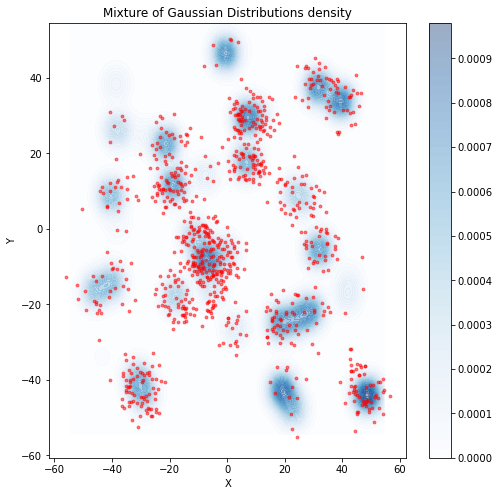

The magnitude of the Stochastic term is 0.229935328709772 whereas the magnitude of the gradient term is 0.009999832468630114
 Voici le step moyen sur toutes les particles 0.02042994492300479, et voici le time moyen auquel on est sur la simu 204.29944923004786


100%|██████████| 10000/10000 [01:37<00:00, 102.94it/s]


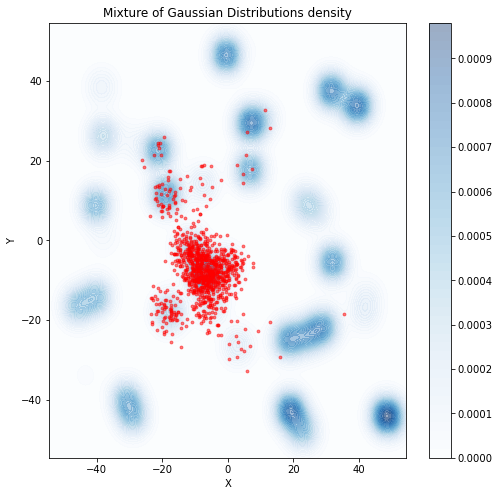

100%|██████████| 10000/10000 [01:37<00:00, 102.06it/s]


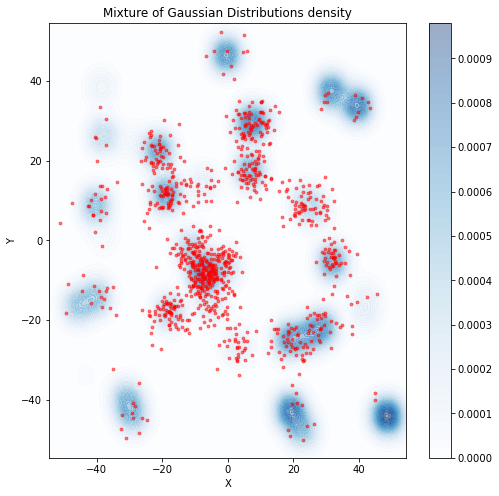

100%|██████████| 10000/10000 [01:38<00:00, 101.14it/s]


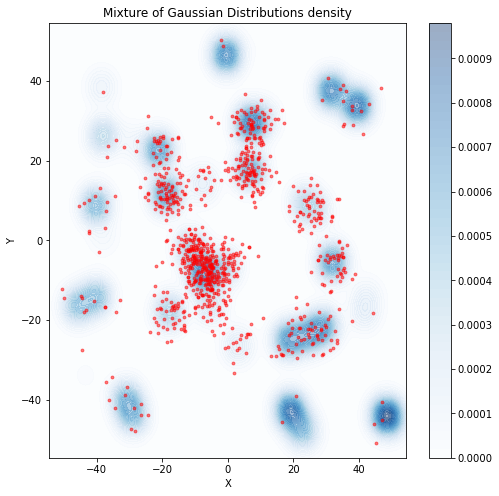

100%|██████████| 10000/10000 [01:35<00:00, 105.02it/s]


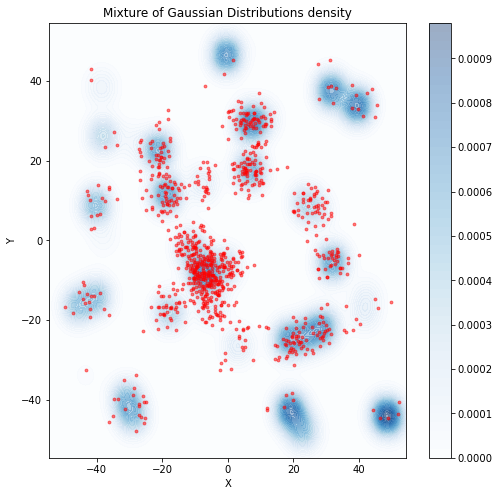

In [70]:
all_traj_ULA_dilation = ULA_dilation(sample_init, 10000, 0.02, weights, centers, covariances, 100, alpha = 0.01, all_traj = True)
all_traj_ULA = ULA(sample_init, 10000, 0.01, weights, centers, covariances, all_traj = True)
all_traj_ULA_geom = ULA_geometric(sample_init, weights, centers, covariances, 0.01, 10000, 5,  all_traj = True)
all_traj_TULA = TULA_dilation(sample_init, 10000, 0.015, weights, centers, covariances, 70, all_traj = True)
all_traj_TULAc = TULAc_dilation(sample_init, 10000, 0.015, weights, centers, covariances, 70, all_traj = True)


In [71]:
np.save('all_traj_ULA_bis.npy', all_traj_ULA)
np.save('all_traj_ULA_geom_bis.npy', all_traj_ULA_geom)
np.save('all_traj_ULA_dilation_bis.npy', all_traj_ULA_dilation)
np.save('all_traj_TULA_bis.npy', all_traj_TULA)
np.save('all_traj_TULAc_bis.npy', all_traj_TULAc)

Evolution of Multimodality Score with the number of iterations for each method : 

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [03:08<00:00, 53.07it/s]


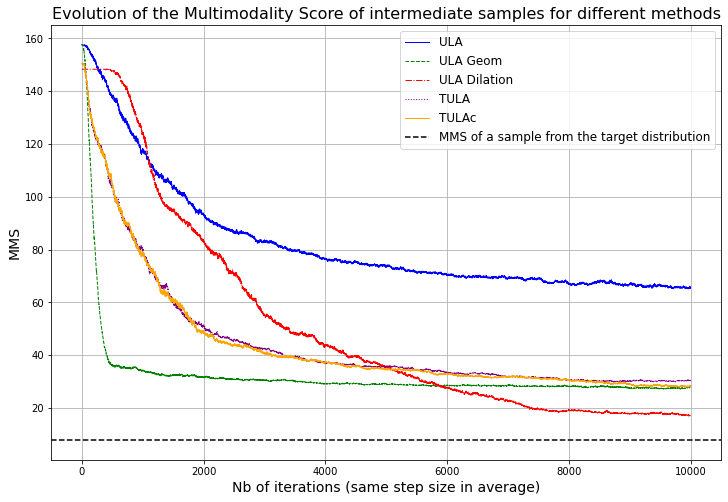

In [72]:
n_iter = 10000
n_samples = 1000
dim = 2
methods = ['ULA', 'ULA Geom', 'ULA Dilation', 'TULA', 'TULAc']
colors = ['blue', 'green', 'red', 'purple', 'orange']
linestyles = ['-', '--', '-.', ':', '-']

MMS_tot = np.zeros((n_iter, len(methods)))

for i in tqdm(range(n_iter)):
    for j, traj in enumerate([all_traj_ULA, all_traj_ULA_geom, all_traj_ULA_dilation, all_traj_TULA, all_traj_TULAc]):
        MMS_tot[i, j] = MMS(traj[i], weights, centers)

plt.figure(figsize=(12, 8))

for i, method in enumerate(methods):
    plt.plot(np.arange(10000), MMS_tot[:, i], label=method, color=colors[i], linestyle=linestyles[i], linewidth=1)

plt.axhline(y=MMS(target_sample, weights, centers), color='black', linestyle='--', label='MMS of a sample from the target distribution')

plt.title('Evolution of the Multimodality Score of intermediate samples for different methods', fontsize=16)
plt.xlabel('Nb of iterations (same step size in average)', fontsize=14)
plt.ylabel('MMS', fontsize=14)

plt.legend(fontsize=12)
plt.grid(True)
plt.show()

Evolution of Wasserstein Distance with the target distribution with the number of iterations for each method : 

100%|██████████| 1000/1000 [04:48<00:00,  3.46it/s]


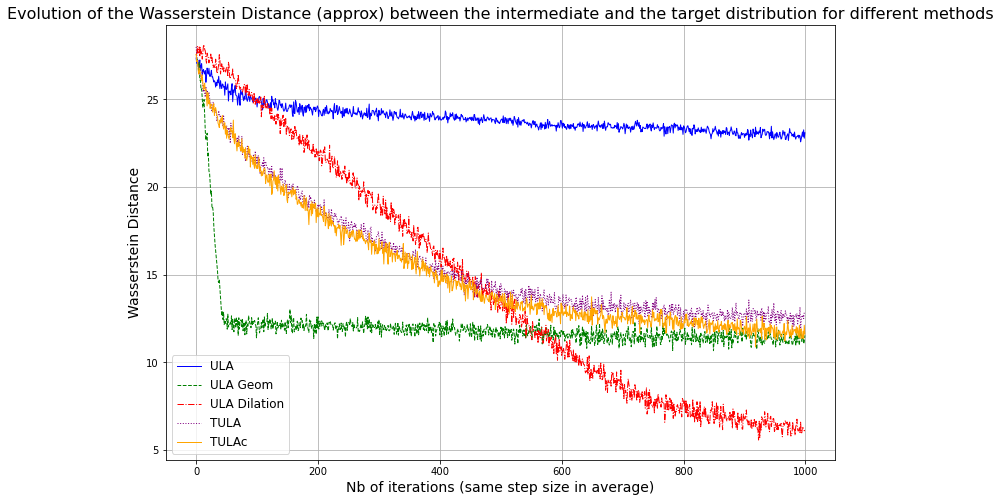

In [74]:
n_iter = 10000
n_samples = 1000
dim = 2
methods = ['ULA', 'ULA Geom', 'ULA Dilation', 'TULA', 'TULAc']
colors = ['blue', 'green', 'red', 'purple', 'orange']
linestyles = ['-', '--', '-.', ':', '-']

wasserstein_2 = np.zeros((1000, len(methods)))

# pas besoin non plus de plot avec un pas de 1
for i in tqdm(range(1000)):

    for j, traj in enumerate([all_traj_ULA, all_traj_ULA_geom, all_traj_ULA_dilation, all_traj_TULA, all_traj_TULAc]):

        wasserstein_2[i, j] = wasserstein_dist_multidim(traj[i*10], target_sample)

plt.figure(figsize=(12, 8))

for i, method in enumerate(methods):
    plt.plot(np.arange(1000), wasserstein_2[:, i], label=method, color=colors[i], linestyle=linestyles[i], linewidth=1)

plt.title('Evolution of the Wasserstein Distance (approx) between the intermediate and the target distribution for different methods', fontsize=16)
plt.xlabel('Nb of iterations (same step size in average)', fontsize=14)
plt.ylabel('Wasserstein Distance', fontsize=14)

plt.legend(fontsize=12)
plt.grid(True)
plt.show()

### Statistical divergences used for evaluation

In this section we define different convergence metrics to measure the discrepancy between the target distribution $\pi$ and the intermediate distributions $\mu_t$ that we use at each iteration. For this we will use an approximation of several statistical divergences, built from samples of the target distribution $\pi$ and from each intermediate distribution. 

------------------------------------------------------------------------------------------------------------------------------------------------------
First, let's define the Kernel Stein Discrepancy (KSD), defined as : 

$ \text{KSD}^2(p_k, \pi) = \mathbb{E}_{(x, x') \sim p_k \otimes p_k} [K(x, x'; \pi, K')] $

where : 
- $K(.)$ is a Kernel that requires the unormalized target distribution and another Kernel $K'(.)$ 

It is defined as : 

$ K(x, y; \pi, K') = \nabla \log \pi(x)^T \nabla \log \pi(y) K'(x, y) + \nabla \log \pi(x)^T \nabla_y K'(x, y) + \nabla_x K'(x, y)^T \nabla \log \pi(y) + \nabla_x \cdot \nabla_y K'(x, y) $

- $K'(.)$ is the Inverse Multiquadratic Kernel, defined as : 

$ K'(x, y) = (1 + \|x - y\|^2)^{-\beta} \quad \text{where} \ \beta \in [0, 1] \ \text{and is here chosen as} \ 0.5 $

We define both Kernels and then a function that takes as arguments the parameters of the target distribution (Gaussian Mixture) and a sample from the intermediate distribution (whose items are consider independant)



In [34]:
multiquad_kernel(np.array([1,0]), np.array([2,2]), -2)

36

To compute the second kernel value, we need to compute the gradients of the Multiquadratic Kernel w.r.t $x$ and $y$, given by : 

- $ \nabla_x K'(x, y) = -2 \beta (1 + \|x - y\|^2)^{-\beta-1} (x - y) $  
- $\nabla_y K'(x, y) = 2 \beta (1 + \|x - y\|^2)^{-\beta-1} (x - y)$


In [36]:
grad_multiquad_kern(np.array([1,0]), np.array([2,2]))

[array([0.06804138, 0.13608276]), array([-0.06804138, -0.13608276])]

In [42]:
compute_kernel(np.array([1,0]), np.array([2,2]), weights, centers, covariances, beta = 0.5)

-0.03632778332938214

In [79]:
intermediate_sample = np.random.multivariate_normal(np.array([0,0]), np.array([[1,0], [0,1]]), 10).reshape(10, 2)

In [80]:
squared_KSD(intermediate_sample, weights, centers, covariances, beta = 0.5)

<class 'int'>


100%|██████████| 5/5 [00:00<00:00, 32.24it/s]


-0.10784803113984484

Calculs précédents à vérifier

------------------------------------------------------------------------------------------------------------------------------------------------------
We define the Kullbach-Leibler divergence between two distributions, given by : 

$ \text{KL}(p_k, \pi) = \mathbb{E}_{x \sim p_k} \left[ \log \frac{p_k(x)}{\pi(x)} \right] $

We can have the rev-KL by switching the roles of $p_k$ and $\pi$ 

Est-ce qu'on peut même le coder sans coder la log densité de $p_k$ ????????


Same with the Wasserstein Distance : 

In [75]:
wasserstein_dist_multidim(target_sample, all_traj_ULA[9000])

23.145783957018544

We skip Maximum Mean Discrepancy (MMD) 

We define the Multimodality Score (MMS) : 

Est ce que l'expected particle by mode c'est bien les poids ? 

In [5]:
MMS(np.array([[0,0], [1, 1]]), weights, centers)

0.4841229182759271

### Convergence of the different methods 

In this part we study the speed of convergence of these methods regarding different metrics. First, we will see the evolution of the Multimodality Score of each method function of the average distance between the modes of our Gaussian Mixture. 

The Multimodality Score as defined in the article "[A Practical Diffusion Path for Sampling](https://arxiv.org/abs/2406.14040)", as the root mean squared error between the actual and expected number of particles per mode. Then, at the end of the simulation, we attribute each particle to its closest mode and compare the proportion of particle in each mode to the true theorical proportion (given by the weights of the Gaussian distributions in the Mixture). 

We are going to compute 10,000 iterations of each method for a constant step size of 0.01 for the classic ULA and ULA with geometric path. For the ULA with dilation path, we take an adaptive step size as in the article but equals in average to 0.01 for the comparison to be fair. 


In [20]:
# Define the covariance matrix
covariances = np.array([[[10, 0], [0, 10]]]*16)  # cov = 10*I_2 -> 16 times the same covariance matrix
weights = np.ones(16) / 16
sample_init = np.random.randn(1000, 2)

Here, we compare the performance and the results of ULA with dilation path depending on the length of the linear schedule chosen. For each path, we will see the evolution of the Multimodality Score depending on the average distance between the modes. We take an average step size of 0.01 and 10,000 iterations, which means that at the end we are at T = 100. 

End_schedule : 5, 10, 20, 30, 50, 70

In [ ]:
#Parameters
nb_iter = 10000
step = 0.01

#Initialization
MMS_result_ULA = np.zeros(20)
dist_AXIS = np.zeros(20)


for i in tqdm(range(20)):
    scale = 6 * (i + 2)
    x = np.linspace(-scale, scale, 4)
    y = np.linspace(-scale, scale, 4)
    xx, yy = np.meshgrid(x, y)
    centers = np.c_[xx.ravel(), yy.ravel()]

    plot = (i % 5 == 0)
    MMS_result_ULA[i] = MMS(ULA(sample_init, nb_iter, step, weights, centers, covariances, plot=plot, vector_result=True), weights, centers)
        
    dist_AXIS[i] = np.linalg.norm(centers[1] - centers[0])

plt.figure(figsize=(10, 10))
plt.plot(dist_AXIS, MMS_result_ULA, color='red', label='MMS for ULA')
plt.xlabel('Distance (norm 2) between two consecutive modes')
plt.ylabel('Multimodality Score')
plt.title('Evolution of the MMS for ULA depending on the distance between modes')
plt.legend()

In [ ]:
#Parameters
n_iter = 10000
step = 0.01
alpha = 0.01
n_schedules = 6
schedules = [5, 10, 20, 30, 50, 70]

#Initialization
MMS_result_dilation = np.zeros((20, n_schedules))
dist_AXIS = np.zeros(20)


for i in tqdm(range(20)):
    scale = 6 * (i + 2)
    x = np.linspace(-scale, scale, 4)
    y = np.linspace(-scale, scale, 4)
    xx, yy = np.meshgrid(x, y)
    centers = np.c_[xx.ravel(), yy.ravel()]

    for j, schedule in enumerate(schedules):
        plot = (i % 5 == 0)
        MMS_result_dilation[i, j] = MMS(ULA_dilation(sample_init, n_iter, step, weights, centers, covariances, schedule, alpha=alpha, plot=plot, vector_result=True), weights, centers)
        
    dist_AXIS[i] = np.linalg.norm(centers[1] - centers[0])

# Results
colors = ['red', 'blue', 'green', 'orange', 'yellow', 'black']
labels = [f'End of the linear schedule : T = {s}' for s in schedules]

for j in range(n_schedules):
    plt.plot(dist_AXIS, MMS_result_dilation[:, j], color=colors[j], label=labels[j])

plt.xlabel('Distance (norm 2) between two consecutive modes')
plt.ylabel('Multimodality Score')
plt.title('Evolution of the MMS for ULA with Dilation path depending on the length of the Schedule')
plt.legend()

We do the exact same experiment for the geometric path, exept that we change the schedules (diverges more easily for big end_schedule ?)

In [ ]:
#Parameters
nb_iter = 10000
step = 0.01
alpha = 0.01
n_schedules = 6
schedules = [3, 5, 10, 15, 30, 50]

#Initialization
MMS_result_geom = np.zeros((20, n_schedules))
dist_AXIS = np.zeros(20)


for i in tqdm(range(20)):
    scale = 6 * (i + 2)
    x = np.linspace(-scale, scale, 4)
    y = np.linspace(-scale, scale, 4)
    xx, yy = np.meshgrid(x, y)
    centers = np.c_[xx.ravel(), yy.ravel()]

    for j, schedule in enumerate(schedules):
        plot = (i % 5 == 0)
        MMS_result_geom[i, j] = MMS(ULA_geometric(sample_init, weights, centers, covariances, step, nb_iter, schedule, plot=plot, vector_result=True), weights, centers)
        
    dist_AXIS[i] = np.linalg.norm(centers[1] - centers[0])

# Results
colors = ['red', 'blue', 'green', 'orange', 'yellow', 'black']
labels = [f'End of the linear schedule : T = {s}' for s in schedules]

for j in range(n_schedules):
    plt.plot(dist_AXIS, MMS_result_geom [:, j], color=colors[j], label=labels[j])

plt.xlabel('Distance (norm 2) between two consecutive modes')
plt.ylabel('Multimodality Score')
plt.title('Evolution of the MMS for ULA with Dilation path depending on the length of the Schedule')
plt.legend()

In [ ]:
#Parameters
n_iter = 10000
step = 0.01
n_schedules = 6
schedules = [5, 10, 20, 30, 50, 70]

#Initialization
MMS_result_dilation_TULA = np.zeros((20, n_schedules))
dist_AXIS = np.zeros(20)


for i in tqdm(range(20)):
    scale = 6 * (i + 2)
    x = np.linspace(-scale, scale, 4)
    y = np.linspace(-scale, scale, 4)
    xx, yy = np.meshgrid(x, y)
    centers = np.c_[xx.ravel(), yy.ravel()]

    for j, schedule in enumerate(schedules):
        plot = (i % 5 == 0)
        MMS_result_dilation_TULA[i, j] = MMS(TULA_dilation(sample_init, n_iter, step, weights, centers, covariances, schedule, plot=plot, vector_result=True), weights, centers)
        
    dist_AXIS[i] = np.linalg.norm(centers[1] - centers[0])

# Results
colors = ['red', 'blue', 'green', 'orange', 'yellow', 'black']
labels = [f'End of the linear schedule : T = {s}' for s in schedules]

for j in range(n_schedules):
    plt.plot(dist_AXIS, MMS_result_dilation_TULA[:, j], color=colors[j], label=labels[j])

plt.xlabel('Distance (norm 2) between two consecutive modes')
plt.ylabel('Multimodality Score')
plt.title('Evolution of the MMS for TULA with Dilation path depending on the length of the Schedule')
plt.legend()

In [ ]:
#Parameters
n_iter = 10000
step = 0.01
n_schedules = 6
schedules = [5, 10, 20, 30, 50, 70]

#Initialization
MMS_result_dilation_TULAc = np.zeros((20, n_schedules))
dist_AXIS = np.zeros(20)


for i in tqdm(range(20)):
    scale = 6 * (i + 2)
    x = np.linspace(-scale, scale, 4)
    y = np.linspace(-scale, scale, 4)
    xx, yy = np.meshgrid(x, y)
    centers = np.c_[xx.ravel(), yy.ravel()]

    for j, schedule in enumerate(schedules):
        plot = (i % 5 == 0)
        MMS_result_dilation_TULAc[i, j] = MMS(TULAc_dilation(sample_init, n_iter, step, weights, centers, covariances, schedule, plot=plot, vector_result=True), weights, centers)
        
    dist_AXIS[i] = np.linalg.norm(centers[1] - centers[0])

# Results
colors = ['red', 'blue', 'green', 'orange', 'yellow', 'black']
labels = [f'End of the linear schedule : T = {s}' for s in schedules]

for j in range(n_schedules):
    plt.plot(dist_AXIS, MMS_result_dilation_TULAc[:, j], color=colors[j], label=labels[j])

plt.xlabel('Distance (norm 2) between two consecutive modes')
plt.ylabel('Multimodality Score')
plt.title('Evolution of the MMS for TULAc with Dilation path depending on the length of the Schedule')
plt.legend()

We plot the comparison of the evolution of MMS for each method and we take the best schedule when we have the choice. For each method, the simulation ends at each iteration at approximately T = 100, for a fair comparison. 

Ps : it may not be perfectly tuned for each method, especially the choice of the schedule. 

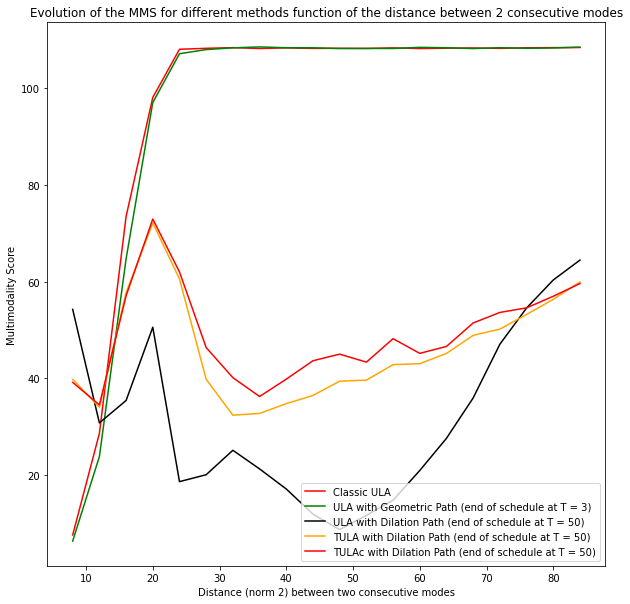

In [30]:
plt.figure(figsize=(10, 10))
plt.plot(dist_AXIS, MMS_result_ULA, color = 'red', label = 'Classic ULA')
plt.plot(dist_AXIS, MMS_result_geom[:, 0], color = 'green', label = 'ULA with Geometric Path (end of schedule at T = 3)')
plt.plot(dist_AXIS, MMS_result_dilation[:, 4], color = 'black', label = 'ULA with Dilation Path (end of schedule at T = 50)')
plt.plot(dist_AXIS, MMS_result_dilation_TULA[:, 4], color = 'orange', label = 'TULA with Dilation Path (end of schedule at T = 50)')
plt.plot(dist_AXIS, MMS_result_dilation_TULAc[:, 4], color = 'red', label = 'TULAc with Dilation Path (end of schedule at T = 50)')
plt.xlabel('Distance (norm 2) between two consecutive modes')
plt.ylabel('Multimodality Score')
plt.title('Evolution of the MMS for different methods function of the distance between 2 consecutive modes')
plt.legend()

Now, we print the evolution of the gradient norm function of the schedule, depending on whether we use or not the dilation path : in 2 different settings. 


Setting 1 : 

In [386]:
x = np.linspace(-80, 80, 4)
y = np.linspace(-80, 80, 4)

xx, yy = np.meshgrid(x, y)

# We define the centers for each mode
centers = np.c_[xx.ravel(), yy.ravel()] ## On a une matrice de 16 lignes et 2 colonnes, chaque ligne correspond à un centre

# Define the covariance matrix
covariances = np.array([[[10, 0], [0, 10]]]*16)  # cov = 10*I_2 -> 16 times the same covariance matrix
weights = np.ones(16) / 16

sample_init = np.random.randn(1000, 2)

100%|██████████| 10000/10000 [01:36<00:00, 103.90it/s]


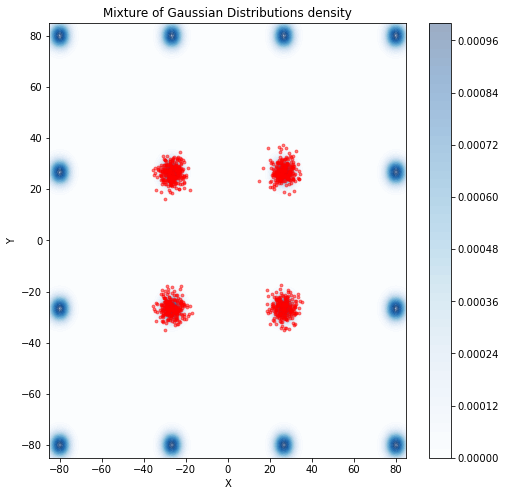

In [47]:
test1 = ULA_test(sample_init, 10000, 0.01, weights, centers, covariances, True)

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/tomrossa/Documents/Imperial College/Research_Project-Imperial_College/experiment_functions.py:123: RuntimeWarning: invalid value encountered in true_divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
100%|██████████| 10000/10000 [01:32<00:00, 108.46it/s]


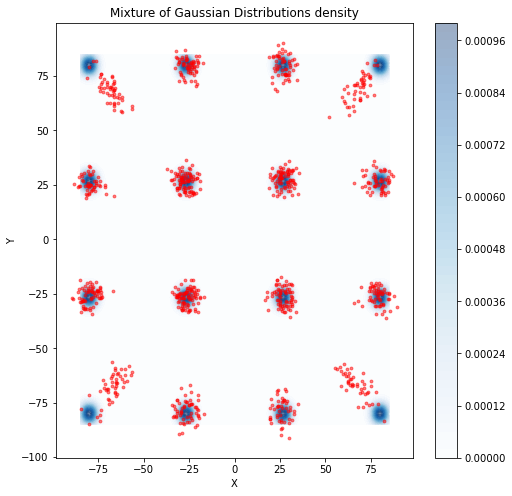

In [56]:
test2 = ULA_dilation_test(sample_init, 10000, 0.01, weights, centers, covariances, 50, alpha = 0.01, plot = True)

100%|██████████| 10000/10000 [01:07<00:00, 149.19it/s]


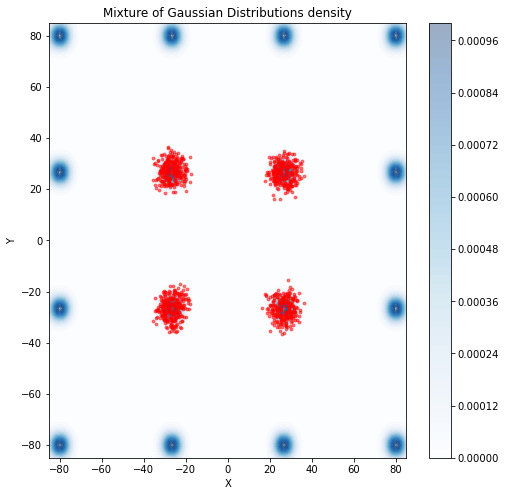

In [57]:
test3 = ULA_dilation_test(sample_init, 10000, 0.01, weights, centers, covariances, 5, alpha = 0.01, plot = True)

We observe an explosion of the gradient when the schedule function is close to 0 for the dilation path. That is why the adaptative step size is useful at the beginning. 

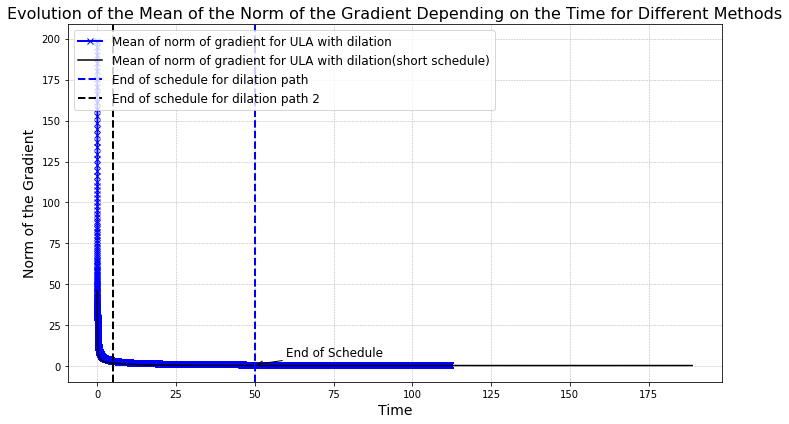

In [60]:
plt.figure(figsize=(10, 6))

#plt.plot(test1[1], test1[0], color='red', linewidth=2, linestyle='-', marker='o', label='Mean of norm of gradient for ULA')
plt.plot(test2[1], test2[0], color='blue', linewidth=2, linestyle='-', marker='x', label='Mean of norm of gradient for ULA with dilation')
plt.plot(test3[1], test3[0], color = 'black', label = 'Mean of norm of gradient for ULA with dilation(short schedule)')

plt.axvline(x=50, color='blue', linestyle='--', linewidth=2, label='End of schedule for dilation path')
plt.axvline(x=5, color='black', linestyle='--', linewidth=2, label='End of schedule for dilation path 2')

plt.xlabel('Time', fontsize=14)
plt.ylabel('Norm of the Gradient', fontsize=14)
plt.title('Evolution of the Mean of the Norm of the Gradient Depending on the Time for Different Methods', fontsize=16)

plt.legend(fontsize=12, loc='upper left')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.annotate('End of Schedule', xy=(50, test2[0][np.argmin(np.abs(test2[1] - 50))]), xytext=(60, test2[0][np.argmin(np.abs(test2[1] - 50))] + 5),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)

plt.tight_layout()
plt.show()


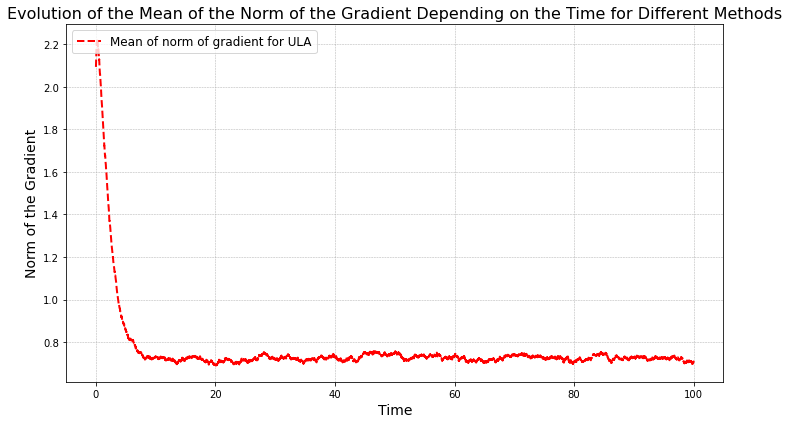

In [69]:
plt.figure(figsize=(10, 6))

plt.plot(test1[1], test1[0], color='red', linewidth=2, linestyle='--', label='Mean of norm of gradient for ULA')

plt.xlabel('Time', fontsize=14)
plt.ylabel('Norm of the Gradient', fontsize=14)
plt.title('Evolution of the Mean of the Norm of the Gradient Depending on the Time for Different Methods', fontsize=16)

plt.legend(fontsize=12, loc='upper left')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


Setting 2 : Closer modes

In [62]:
x = np.linspace(-20, 20, 4)
y = np.linspace(-20, 20, 4)

xx, yy = np.meshgrid(x, y)

# We define the centers for each mode
centers = np.c_[xx.ravel(), yy.ravel()] ## On a une matrice de 16 lignes et 2 colonnes, chaque ligne correspond à un centre

# Define the covariance matrix
covariances = np.array([[[3, 0], [0, 3]]]*16)  # cov = 10*I_2 -> 16 times the same covariance matrix
weights = np.ones(16) / 16

sample_init = np.random.randn(1000, 2)

100%|██████████| 10000/10000 [01:19<00:00, 125.63it/s]


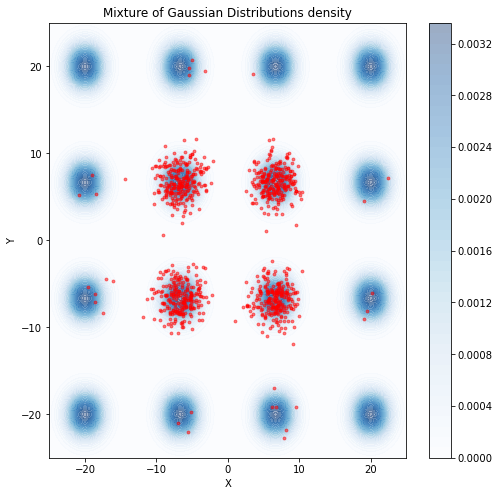

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/tomrossa/Documents/Imperial College/Research_Project-Imperial_College/experiment_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
/Users/tomrossa/Documents/Imperial College/Research_Project-Imperial_College/experiment_functions.py:123: RuntimeWarning: invalid value encountered in true_divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_53249/1287870248.py:37: RuntimeWarning: invalid value encountered in multiply
  grad_update = step_tab[:, np.newaxis] * grad
100%|██████████| 10000/10000 [01:04<00:00, 155.16it/s]


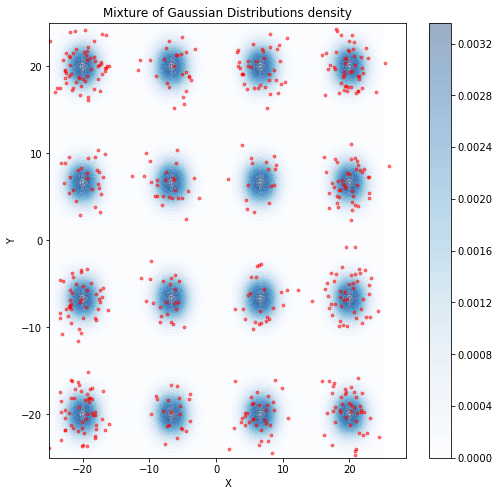

100%|██████████| 10000/10000 [01:03<00:00, 156.30it/s]


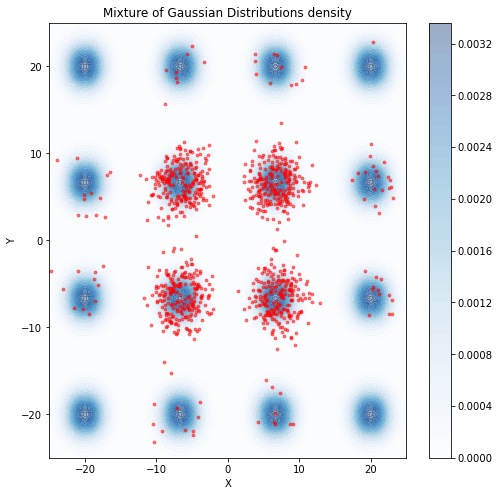

In [63]:
test1 = ULA_test(sample_init, 10000, 0.01, weights, centers, covariances, True)
test2 = ULA_dilation_test(sample_init, 10000, 0.01, weights, centers, covariances, 50, alpha = 0.01, plot = True)
test3 = ULA_dilation_test(sample_init, 10000, 0.01, weights, centers, covariances, 5, alpha = 0.01, plot = True)

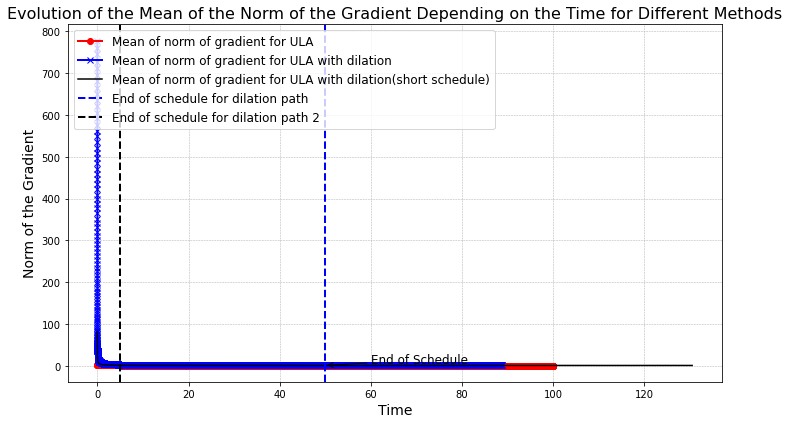

In [64]:
plt.figure(figsize=(10, 6))

plt.plot(test1[1], test1[0], color='red', linewidth=2, linestyle='-', marker='o', label='Mean of norm of gradient for ULA')
plt.plot(test2[1], test2[0], color='blue', linewidth=2, linestyle='-', marker='x', label='Mean of norm of gradient for ULA with dilation')
plt.plot(test3[1], test3[0], color = 'black', label = 'Mean of norm of gradient for ULA with dilation(short schedule)')

plt.axvline(x=50, color='blue', linestyle='--', linewidth=2, label='End of schedule for dilation path')
plt.axvline(x=5, color='black', linestyle='--', linewidth=2, label='End of schedule for dilation path 2')

plt.xlabel('Time', fontsize=14)
plt.ylabel('Norm of the Gradient', fontsize=14)
plt.title('Evolution of the Mean of the Norm of the Gradient Depending on the Time for Different Methods', fontsize=16)

plt.legend(fontsize=12, loc='upper left')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.annotate('End of Schedule', xy=(50, test2[0][np.argmin(np.abs(test2[1] - 50))]), xytext=(60, test2[0][np.argmin(np.abs(test2[1] - 50))] + 5),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)

plt.tight_layout()
plt.show()


TESTS / TO SUPPRESS

In [ ]:
def ULA_test(x_init, nb_iter, step, weights, centers, covariances, plot = True, vector_result = False): 

    x = x_init

    gradient_norm = np.zeros(nb_iter)

    time = np.zeros(nb_iter)

    for i in tqdm(range(nb_iter)):

        time[i] = step * (i+1)

        # Each iteration we compute the gradient of the target distribution and update the position of the particles
        grad = grad_multimodal_opti(x, weights, centers, covariances)

        gradient_norm[i] = np.mean(np.linalg.norm(grad, axis = 1)) #moyenne des normes des vecteurs à chaque itération

        noise =  np.sqrt(2 * step) * np.random.randn(1000, 2)

        x = x + step * grad + noise

    if plot: 

        generate_multimodal(centers, covariances, weights, x)

        return gradient_norm, time

    return gradient_norm, time


In [187]:
def ULA_dilation_test(x_init, nb_iter, step, weights, centers, covariances, end_schedule,  bound = 100, alpha = 1, plot = True, vector_result = False): 

    x = x_init

    sample_size = x.shape[0]

    dim_var = x.shape[1]

    gradient_norm = np.zeros(nb_iter)

    sto_norm = np.zeros(nb_iter)

    time_mean = np.zeros(nb_iter)

    time = np.zeros(sample_size)

    step_tab = np.full(sample_size, step) 

    grad_term = np.zeros(nb_iter)

    step_tab_mean = np.zeros(nb_iter)

    for i in tqdm(range(nb_iter)):

        time += step_tab

        time_mean[i] = np.nanmean(time)

        schedule = np.minimum(end_schedule, time) / end_schedule #end_schedule is the date from which we are using the reel target distribution

        gamma = 1 / np.sqrt(schedule)

        # Each iteration we compute the gradient of the target distribution and update the position of the particle
        grad = gamma[:, np.newaxis] * grad_multimodal_opti(gamma[:, np.newaxis] * x, weights, centers, covariances)
    
        grad_nor = np.linalg.norm(grad, axis = 1)
        gradient_norm[i] = np.nanmean(grad_nor)

        step_tab = np.minimum(1 / (grad_nor + 1e-8), bound) * alpha #Vecteur de taille nb_particles qui donne le step pour chaque particle à cette itération
        step_tab_mean[i] = np.nanmean(step_tab)

        noise =  np.sqrt(2 * step_tab)[:, np.newaxis] * np.random.randn(sample_size, dim_var) #ON APPLIQUE LE PAS ADAPTATIF AU GRADIENT ET NON AU TERME STOCHASTIQUE 
        #noise = np.sqrt(2 * step) * np.random.randn(sample_size, dim_var)
        sto_norm[i] = np.nanmean(np.linalg.norm(noise, axis = 1))

        grad_update = step_tab[:, np.newaxis] * grad

        grad_term[i] = np.nanmean(np.linalg.norm(grad_update, axis = 1))
        
        x = x + grad_update + noise

    if plot: 

        generate_multimodal(centers, covariances, weights, x)

        print(f'Le temps écoulé est de {time_mean[-1]}')

        return gradient_norm, sto_norm, time_mean, grad_term, step_tab_mean

    return gradient_norm, sto_norm, time_mean, grad_term, step_tab_mean


100%|██████████| 15000/15000 [02:18<00:00, 108.21it/s]


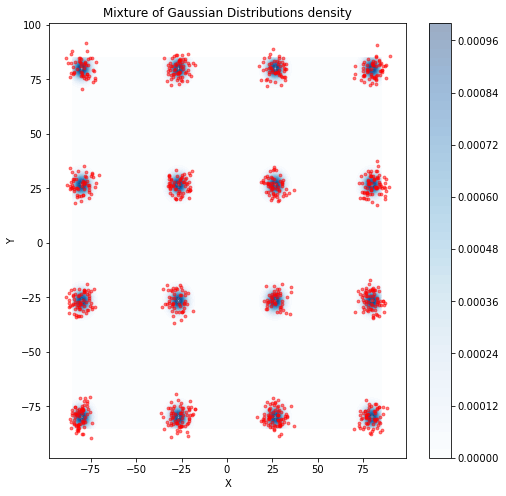

Le temps écoulé est de 219.46445257988373


In [186]:
w = ULA_dilation_test(sample_init, 15000, 0.01, weights, centers, covariances, 70, alpha = 0.01)

In [436]:
def TULA_dilation_test(x_init, nb_iter, step, weights, centers, covariances, start_schedule, end_schedule,
                   plot = True, vector_result = False, all_traj = False): 

    x = x_init

    sample_size = x.shape[0]

    dim_var = x.shape[1]

    stochastic_term = np.zeros(nb_iter)

    gradient_term = np.zeros(nb_iter)

    gradient_norm = np.zeros(nb_iter)

    time_iter = np.zeros(nb_iter)

    time = np.full(sample_size, -step) #Each particle follows its own time-line ? ? 

    step_tab = np.full(sample_size, step)

    all_traj_vect = np.zeros((nb_iter, sample_size, dim_var))

    for i in tqdm(range(nb_iter)):

        time += step_tab

        time_iter[i] = np.nanmean(time)

        #schedule = np.minimum(start_schedule + np.minimum(end_schedule, time) / end_schedule, 1)
        #schedule = np.minimum(np.exp(-(end_schedule - np.full(sample_size, i)) / start_schedule), 1)
        schedule = np.minimum(np.exp(-(18000 - np.full(sample_size, i)) / 1900), 1)
        
        if i % 100000 == 0:
            print(f'Le premier schedule est de {np.mean(schedule)}')

        gamma = 1 / np.sqrt(schedule)

        # Each iteration we compute the gradient of the target distribution and update the position of the particle
        grad = gamma[:, np.newaxis] * grad_multimodal_opti(gamma[:, np.newaxis] * x, weights, centers, covariances)

        grad_nor = np.linalg.norm(grad, axis = 1)
        gradient_norm[i] = np.nanmean(grad_nor)

        g_step = step_tab / (1 + step * np.linalg.norm(grad, axis = 1)) #vector of size sample_size

        grad_update = g_step[:, np.newaxis] * grad

        gradient_term[i] = np.nanmean(np.linalg.norm(grad_update, axis = 1))

        noise =  np.sqrt(2 * step_tab)[:, np.newaxis] * np.random.randn(sample_size, dim_var) #bien terme à terme pour sqrt 
        
        stochastic_term[i] = np.nanmean(np.linalg.norm(noise, axis = 1))

        x = x + grad_update + noise

        if all_traj:

            all_traj_vect[i] = x

    if plot: 
        generate_multimodal(centers, covariances, weights, x)

    return all_traj_vect#gradient_term, gradient_norm, stochastic_term, time_iter



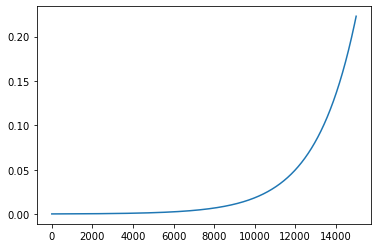

In [438]:
schedule = np.zeros(15000)

for i in range(15000):

    schedule[i] = np.minimum(np.exp(-(18000 - i) / 2000), 1)

plt.plot(np.arange(15000), schedule)


SChedules Expo : 1 -> 13000 / 2000
2 -> 13000 / 1500
3 -> 13000 / 1300
4 -> 13000 / 1700

In [384]:
#Parameters
n_iter = 15000
step = 0.01
n_schedules = 5
schedules = [10, 30, 70, 100, 120]

#Initialization
MMS_result_dilation_TULAc = np.zeros((20, n_schedules))
dist_AXIS = np.zeros(20)


for i in tqdm(range(20)):
    scale = 6 * (i + 2)
    x = np.linspace(-scale, scale, 4)
    y = np.linspace(-scale, scale, 4)
    xx, yy = np.meshgrid(x, y)
    centers = np.c_[xx.ravel(), yy.ravel()]

    for j, schedule in enumerate(schedules):
        MMS_result_dilation_TULAc[i, j] = MMS(TULAc_dilation(sample_init, n_iter, step, weights, centers, covariances, 0.0001, schedule, plot=False, vector_result=True), weights, centers)
        
    dist_AXIS[i] = np.linalg.norm(centers[1] - centers[0])

# Results
colors = ['red', 'blue', 'green', 'orange', 'yellow', 'black']
labels = [f'End of the linear schedule : T = {s}' for s in schedules]

for j in range(n_schedules):
    plt.plot(dist_AXIS, MMS_result_dilation_TULAc[:, j], color=colors[j], label=labels[j])

plt.xlabel('Distance (norm 2) between two consecutive modes')
plt.ylabel('Multimodality Score')
plt.title('Evolution of the MMS for TULAc with Dilation path depending on the length of the Schedule')
plt.legend()

100%|██████████| 15000/15000 [02:34<00:00, 97.05it/s] 


The magnitude of the Stochastic term is 0.17728614010557278 whereas the magnitude of the gradient term is 0.001456610177355525
 Voici le step moyen sur toutes les particles 0.01000000000000057, et voici le time moyen auquel on est sur la simu 150.00000000000855


/Users/tomrossa/Documents/Imperial College/Research_Project-Imperial_College/experiment_functions.py:124: RuntimeWarning: invalid value encountered in true_divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
  0%|          | 0/20 [03:55<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
#Parameters
n_iter = 15000
step = 0.01
n_schedules = 5
schedules = [10, 30, 70, 100, 120]

#Initialization
MMS_result_dilation_TUL = np.zeros((20, n_schedules))
dist_AXIS = np.zeros(20)


for i in tqdm(range(20)):
    scale = 6 * (i + 2)
    x = np.linspace(-scale, scale, 4)
    y = np.linspace(-scale, scale, 4)
    xx, yy = np.meshgrid(x, y)
    centers = np.c_[xx.ravel(), yy.ravel()]

    for j, schedule in enumerate(schedules):
        plot = False
        MMS_result_dilation_TULA[i, j] = MMS(TULA_dilation(sample_init, n_iter, step, weights, centers, covariances, 0.0001, schedule, plot=plot, vector_result=True), weights, centers)
        
    dist_AXIS[i] = np.linalg.norm(centers[1] - centers[0])

# Results
colors = ['red', 'blue', 'green', 'orange', 'yellow', 'black']
labels = [f'End of the linear schedule : T = {s}' for s in schedules]

for j in range(n_schedules):
    plt.plot(dist_AXIS, MMS_result_dilation_TULAc[:, j], color=colors[j], label=labels[j])

plt.xlabel('Distance (norm 2) between two consecutive modes')
plt.ylabel('Multimodality Score')
plt.title('Evolution of the MMS for TULAc with Dilation path depending on the length of the Schedule')
plt.legend()

In [ ]:
#Parameters
n_iter = 15000
step = 0.01
alpha = 0.01
n_schedules = 5
schedules = [10, 30, 70, 100, 120]

#Initialization
MMS_result_dilation = np.zeros((20, n_schedules))
dist_AXIS = np.zeros(20)


for i in tqdm(range(20)):
    scale = 6 * (i + 2)
    x = np.linspace(-scale, scale, 4)
    y = np.linspace(-scale, scale, 4)
    xx, yy = np.meshgrid(x, y)
    centers = np.c_[xx.ravel(), yy.ravel()]

    for j, schedule in enumerate(schedules):
        plot = False
        MMS_result_dilation[i, j] = MMS(ULA_dilation_test(sample_init, n_iter, step, weights, centers, covariances, schedule, alpha=alpha, plot=plot, vector_result=True), weights, centers)
        
    dist_AXIS[i] = np.linalg.norm(centers[1] - centers[0])

# Results
colors = ['red', 'blue', 'green', 'orange', 'yellow', 'black']
labels = [f'End of the linear schedule : T = {s}' for s in schedules]

for j in range(n_schedules):
    plt.plot(dist_AXIS, MMS_result_dilation[:, j], color=colors[j], label=labels[j])

plt.xlabel('Distance (norm 2) between two consecutive modes')
plt.ylabel('Multimodality Score')
plt.title('Evolution of the MMS for ULA with Dilation path depending on the length of the Schedule')
plt.legend()